# 🚦 Predicting and Explaining Vehicle Collision Causes (2020–2025)

**Overview:**  
This notebook analyzes U.S. motor vehicle collisions from **2020 to 2025** to:

- **Predict contributing causes** (e.g., speeding, distraction, mechanical failure) using **multi-label classification**.  
- **Quantify the causal impact** of environmental factors like **lighting, weather, and time of day** using **causal inference techniques**.  
- Provide **interpretable insights** with **Explainable AI (LIME/SHAP)** to inform policy and safety improvements.


# 1. Importing the libraries
> Load all necessary Python libraries for data manipulation, visualization, and modeling.

In [1]:
import re
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats

import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from imblearn.over_sampling import RandomOverSampler

# 2. Load Dataset

> We will load the **Motor Vehicle Collisions - Crashes** dataset from the U.S. Government open data portal.

In [2]:
# loading dataset
df = pd.read_csv('data/Motor_Vehicle_Collisions_Crashes.csv')

In [3]:
# Viewing the first 5 rows of the dataset
df.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,2.0,0.0,0,0,0,0,2,0,Aggressive Driving/Road Rage,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,1.0,0.0,0,0,0,0,1,0,Pavement Slippery,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,11/01/2023,1:29,BROOKLYN,11230.0,40.62179,-73.970024,"(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,1.0,0.0,0,0,0,0,1,0,Unspecified,Unspecified,Unspecified,NaN,NaN,4675373,Moped,Sedan,Sedan,NaN,NaN
3,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Following Too Closely,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
4,09/21/2022,13:21,NaN,NaN,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


In [4]:
# Shape of the dataset
rows, columns = df.shape
print(f"The dataset has {rows:,} rows and {columns} columns.")

The dataset has 2,216,469 rows and 29 columns.


## 3. Data Exploration

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2216469 entries, 0 to 2216468
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CRASH DATE                     object 
 1   CRASH TIME                     object 
 2   BOROUGH                        object 
 3   ZIP CODE                       object 
 4   LATITUDE                       float64
 5   LONGITUDE                      float64
 6   LOCATION                       object 
 7   ON STREET NAME                 object 
 8   CROSS STREET NAME              object 
 9   OFF STREET NAME                object 
 10  NUMBER OF PERSONS INJURED      float64
 11  NUMBER OF PERSONS KILLED       float64
 12  NUMBER OF PEDESTRIANS INJURED  int64  
 13  NUMBER OF PEDESTRIANS KILLED   int64  
 14  NUMBER OF CYCLIST INJURED      int64  
 15  NUMBER OF CYCLIST KILLED       int64  
 16  NUMBER OF MOTORIST INJURED     int64  
 17  NUMBER OF MOTORIST KILLED      int64  
 18  CO

In [6]:
df.describe()

,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,COLLISION_ID
count,1.976146e+06,1.976146e+06,2.216451e+06,2.216438e+06,2.216469e+06,2.216469e+06,2.216469e+06,2.216469e+06,2.216469e+06,2.216469e+06,2.216469e+06
mean,4.059154e+01,-7.368635e+01,3.277898e-01,1.583171e-03,5.949824e-02,7.823254e-04,2.911929e-02,1.249736e-04,2.345496e-01,6.460726e-04,3.262898e+06
std,2.319124e+00,4.312143e+00,7.146826e-01,4.204107e-02,2.498776e-01,2.859733e-02,1.704144e-01,1.121875e-02,6.758336e-01,2.780081e-02,1.509422e+06
min,0.000000e+00,-2.013600e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.200000e+01
25%,4.066735e+01,-7.397454e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.190238e+06
50%,4.072032e+01,-7.392677e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.744525e+06
75%,4.076956e+01,-7.386658e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.298858e+06
max,4.334444e+01,0.000000e+00,4.300000e+01,8.000000e+00,2.700000e+01,6.000000e+00,4.000000e+00,2.000000e+00,4.300000e+01,5.000000e+00,4.853309e+06


## Initial Observations

1. **Temporal completeness:**  
   - `Crash Date` and `Crash Time` have no missing values, so trend analysis by year, month, weekday, and hour is reliable.

2. **Target sparsity:**  
   - `Contributing Factor Vehicle 1` is almost always present.  
   - Factors 2–5 are highly sparse; missing values can be treated as “no contributing factor” for multi-label analysis.

3. **Spatial data mostly complete:**  
   - Latitude, longitude, and borough are mostly available, enabling geographic analysis.  
   - A small fraction of missing values can be filled with “Unknown” if needed.

In [7]:
# -----------------------------
# IMPORTS
# -----------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import lightgbm as lgb

## Load n clean data

In [33]:
# Load dataset
df = pd.read_csv("data/Motor_Vehicle_Collisions_Crashes.csv")

# Convert date
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'], errors='coerce')

# Keep only years: 2022, 2023, 2024
df = df[df['CRASH DATE'].dt.year.isin([2022, 2023, 2024])]

# Drop the column from the main dataframe
df = df_clean.drop(columns=['COLLISION_ID'], errors='ignore')


# Fill NaN
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(0)

cat_cols = df.select_dtypes(include="object").columns
df[cat_cols] = df[cat_cols].fillna("Unknown")

NameError: name 'df_clean' is not defined

# Visualizations

In [ ]:
# Ensure CRASH_HOUR exists
if 'CRASH_HOUR' not in df.columns:
    # Extract hour from CRASH TIME (assuming it's HH:MM format)
    df['CRASH_HOUR'] = pd.to_datetime(df['CRASH TIME'], errors='coerce').dt.hour

# Now plot
plt.figure(figsize=(10,5))
sns.countplot(x='CRASH_HOUR', data=df, palette='viridis')
plt.title('Accidents by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Accidents')
plt.yscale('log')  # optional log scale if skewed
plt.show()

In [ ]:
if 'CRASH_DAY' not in df.columns:
    df['CRASH_DAY'] = pd.to_datetime(df['CRASH DATE'], errors='coerce').dt.dayofweek

plt.figure(figsize=(8,5))
sns.countplot(x='CRASH_DAY', data=df, palette='magma')
plt.title('Accidents by Day of Week (0=Monday)')
plt.xlabel('Day of Week')
plt.ylabel('Number of Accidents')
plt.yscale('log')
plt.show()

In [ ]:
if 'CRASH_MONTH' not in df.columns:
    df['CRASH_MONTH'] = pd.to_datetime(df['CRASH DATE'], errors='coerce').dt.month

plt.figure(figsize=(10,5))
sns.countplot(x='CRASH_MONTH', data=df, palette='coolwarm')
plt.title('Accidents by Month')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.yscale('log')
plt.show()

In [ ]:
borough_counts = df['BOROUGH'].value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x=borough_counts.index, y=borough_counts.values, palette='Set2')
plt.title('Accidents by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Accidents (log scale)')
plt.yscale('log')
plt.show()

In [ ]:
# -----------------------------
# 6) Heatmap for Top Contributing Factors vs Borough
# -----------------------------
if 'BOROUGH' in df.columns:
    # Recompute top factors
    top_factors = df['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().nlargest(10)
    top_factors_list = top_factors.index.tolist()
    
    heatmap_data = df[df['CONTRIBUTING FACTOR VEHICLE 1'].isin(top_factors_list)]
    heatmap_data = pd.crosstab(
        heatmap_data['CONTRIBUTING FACTOR VEHICLE 1'], 
        heatmap_data['BOROUGH']
    )
    
    plt.figure(figsize=(10,6))
    sns.heatmap(
        heatmap_data, 
        annot=True, fmt='d', 
        cmap='YlOrRd', 
        cbar_kws={'label': 'Number of Accidents'}
    )
    plt.title('Heatmap: Top Contributing Factors vs Borough')
    plt.xlabel('Borough')
    plt.ylabel('Contributing Factor')
    plt.show()


In [ ]:
# -----------------------------
# Top N Contributing Factors Bar Plot
# -----------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure TARGET column exists
if 'CONTRIBUTING FACTOR VEHICLE 1' in df.columns:
    TARGET_COL = 'CONTRIBUTING FACTOR VEHICLE 1'
else:
    TARGET_COL = 'TARGET'  # fallback if column renamed

# 1. Determine the top N most frequent values in the TARGET column
N = 15  # Top 15 factors
top_factors = df[TARGET_COL].value_counts().head(N).index
df_top_factors = df[df[TARGET_COL].isin(top_factors)].copy()

# 2. Create a horizontal bar plot (y-axis = factors)
plt.figure(figsize=(14, 7))
sns.countplot(
    data=df_top_factors, 
    y=TARGET_COL, 
    order=top_factors, 
    palette='viridis',
    log=True  # Log scale for count
)

# 3. Add a clear, descriptive title
plt.title(f'Frequency of Top {N} Contributing Factors ({TARGET_COL})', fontsize=16)

# 4. Label axes
plt.xlabel('Count (log scale)', fontsize=12)
plt.ylabel('Contributing Factor', fontsize=12)

# 5. Improve layout
plt.tight_layout()
plt.show()


In [ ]:
import plotly.express as px

# -----------------------------
# Scatter Map of Crash Locations
# -----------------------------

# Filter out invalid coordinates
df_map = df[(df['LATITUDE'] != 0.0) & (df['LONGITUDE'] != 0.0)].copy()

# Sample to avoid overloading the plot
sample_size = min(100000, len(df_map))
df_sample = df_map.sample(n=sample_size, random_state=42)

# NYC coordinates for centering the map
nyc_latitude = 40.7128
nyc_longitude = -74.0060

# Create the scatter map
fig = px.scatter_mapbox(
    df_sample,
    lat='LATITUDE',
    lon='LONGITUDE',
    hover_data=['ON STREET NAME', 'CROSS STREET NAME', 'CONTRIBUTING FACTOR VEHICLE 1'],  # optional details
    zoom=10,
    center={'lat': nyc_latitude, 'lon': nyc_longitude},
    mapbox_style='carto-positron',
    title=f'Motor Vehicle Crash Locations in NYC (sample {sample_size})',
    height=600
)

# Improve layout
fig.update_layout(margin={'r':0, 't':50, 'l':0, 'b':0})
fig.show()

# Select 7 Target Classes

In [ ]:
top_classes = [
    "Driver Inattention/Distraction",
    "Failure to Yield Right-of-Way",
    "Following Too Closely",
    "Backing Unsafely",
    "Other Vehicular",
    "Passing or Lane Usage Improper",
    "Passing Too Closely"
]

df_filtered = df[df["CONTRIBUTING FACTOR VEHICLE 1"].isin(top_classes)].copy()

X = df_filtered.drop(columns=["CONTRIBUTING FACTOR VEHICLE 1"])
y = df_filtered["CONTRIBUTING FACTOR VEHICLE 1"]

print("[INFO] Value counts before resampling:")
y.value_counts()


# Train/Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"[INFO] X_train: {X_train.shape}, X_test: {X_test.shape}")

# oversample some, undersample others

In [ ]:
# Count classes
class_counts = y_train.value_counts()
print("[INFO] Training class distribution:")
print(class_counts)

# Define target per-class sizes
majority = "Driver Inattention/Distraction"

# Set target counts:
undersample_target = int(class_counts.mean())        # reduce majority
oversample_target = int(class_counts.mean() * 1.2)   # boost minorities

sampling_strategy = {}

for cls, cnt in class_counts.items():
    if cls == majority:
        sampling_strategy[cls] = undersample_target
    else:
        sampling_strategy[cls] = oversample_target

print("\n[INFO] Sampling strategy:")
print(sampling_strategy)

# controlled sampling

In [34]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Count original distribution
class_counts = y_train.value_counts()
print("[INFO] Original training class distribution:")
print(class_counts)

majority = class_counts.idxmax()
majority_count = class_counts.max()
avg_count = int(class_counts.mean())

# --- Define undersampling target for the majority class ---
undersample_target = avg_count  

# --- Define oversampling target for minority classes ---
oversample_target = int(avg_count * 1.2)

print(f"\n[INFO] Undersample target: {undersample_target}")
print(f"[INFO] Oversample target: {oversample_target}")

# ---- 1) Undersample majority ----
under_strategy = {majority: undersample_target}
rus = RandomUnderSampler(sampling_strategy=under_strategy, random_state=42)

X_under, y_under = rus.fit_resample(X_train, y_train)

print("\n[INFO] After undersampling majority:")
print(pd.Series(y_under).value_counts())

# ---- 2) Oversample minority ----
over_strategy = {}

for cls, cnt in pd.Series(y_under).value_counts().items():
    if cls != majority:
        over_strategy[cls] = oversample_target

ros = RandomOverSampler(sampling_strategy=over_strategy, random_state=42)

X_train_res, y_train_res = ros.fit_resample(X_under, y_under)

print("\n[INFO] After oversampling minorities:")
print(pd.Series(y_train_res).value_counts())

[INFO] Original training class distribution:
Driver Inattention/Distraction    57729
Failure to Yield Right-of-Way     16234
Following Too Closely             14616
Passing or Lane Usage Improper    10182
Passing Too Closely                8156
Backing Unsafely                   7071
Other Vehicular                    6760
Name: CONTRIBUTING FACTOR VEHICLE 1, dtype: int64

[INFO] Undersample target: 17249
[INFO] Oversample target: 20698

[INFO] After undersampling majority:
Driver Inattention/Distraction    17249
Failure to Yield Right-of-Way     16234
Following Too Closely             14616
Passing or Lane Usage Improper    10182
Passing Too Closely                8156
Backing Unsafely                   7071
Other Vehicular                    6760
Name: CONTRIBUTING FACTOR VEHICLE 1, dtype: int64

[INFO] After oversampling minorities:
Backing Unsafely                  20698
Failure to Yield Right-of-Way     20698
Following Too Closely             20698
Other Vehicular                 

# Test/Validation Split

In [35]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_res, y_train_res,
    test_size=0.1,
    stratify=y_train_res,
    random_state=42
)

print(f"[INFO] Training rows: {X_tr.shape[0]}, Validation rows: {X_val.shape[0]}")

[INFO] Training rows: 127293, Validation rows: 14144


# Encode Categorical Columns

In [36]:
X_tr_enc = X_tr.copy()
X_val_enc = X_val.copy()

for col in cat_cols:
    if col in X_tr_enc.columns:
        le = LabelEncoder()
        le.fit(pd.concat([X_tr_enc[col], X_val_enc[col]]).astype(str))
        X_tr_enc[col] = le.transform(X_tr_enc[col].astype(str))
        X_val_enc[col] = le.transform(X_val_enc[col].astype(str))


# Encode Target

In [37]:
le_target = LabelEncoder()
y_tr_enc = le_target.fit_transform(y_tr)
y_val_enc = le_target.transform(y_val)


# Fixing Time

In [38]:
def fix_datetime(df):
    for col in df.columns:
        if np.issubdtype(df[col].dtype, np.datetime64):
            df[col] = df[col].view('int64')   # convert to integer nanoseconds
    return df

X_tr_enc = fix_datetime(X_tr_enc)
X_val_enc = fix_datetime(X_val_enc)

# Model training

In [39]:
# -----------------------------
# 9) CREATE LIGHTGBM DATASETS
# -----------------------------
train_data = lgb.Dataset(X_tr_enc, label=y_tr_enc)
val_data   = lgb.Dataset(X_val_enc, label=y_val_enc, reference=train_data)

print("[INFO] LightGBM datasets created.")


[INFO] LightGBM datasets created.


In [40]:
# -----------------------------
# 10) FAST GPU LIGHTGBM PARAMS
# -----------------------------
params = {
    "objective": "multiclass",
    "num_class": len(np.unique(y_tr_enc)),

    # ---------- GPU SETTINGS ----------
    "device": "gpu",
    "gpu_platform_id": 0,
    "gpu_device_id": 0,
    "max_bin": 255,         # GPU requires 255 bins for best speed
    "bin_construct_sample_cnt": 200000,  # speeds up binning

    # ---------- SPEED & STABILITY ----------
    "learning_rate": 0.05,   # slightly higher → faster convergence
    "num_leaves": 80,        # balanced (not too deep)
    "max_depth": -1,         # let leaves control depth
    "min_data_in_leaf": 60,  # prevents overfitting → faster
    "feature_fraction": 0.9, # random feature sampling for speed
    "bagging_fraction": 0.9,
    "bagging_freq": 3,

    # ---------- REGULARIZATION ----------
    "lambda_l1": 1.0,
    "lambda_l2": 1.0,

    # ---------- METRIC ----------
    "metric": "multi_logloss",
    "verbose": -1
}

# Use fewer boosting rounds + smart early stopping
num_boost_round = 1500

callbacks = [
    lgb.early_stopping(
        stopping_rounds=80,   # stops earlier → prevents long training
        first_metric_only=False,
        verbose=True
    ),
    lgb.log_evaluation(period=50)
]

# f1 metic

In [41]:
def weighted_f1_eval(y_pred, dataset):
    y_true = dataset.get_label().astype(int)
    n_classes = len(np.unique(y_true))
    y_pred_class = np.argmax(y_pred.reshape(-1, n_classes), axis=1)
    f1 = f1_score(y_true, y_pred_class, average="weighted")
    return "weighted_f1", f1, True


# Train model

In [42]:
callbacks = [
    lgb.early_stopping(stopping_rounds=100),
    lgb.log_evaluation(period=50)
]

print("[INFO] Training LightGBM...")
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=5000,
    valid_sets=[val_data],
    feval=weighted_f1_eval,
    callbacks=callbacks
)


[INFO] Training LightGBM...
Training until validation scores don't improve for 100 rounds
[50]	valid_0's multi_logloss: 1.45992	valid_0's weighted_f1: 0.453257
[100]	valid_0's multi_logloss: 1.3835	valid_0's weighted_f1: 0.482357
[150]	valid_0's multi_logloss: 1.33095	valid_0's weighted_f1: 0.508437
[200]	valid_0's multi_logloss: 1.28627	valid_0's weighted_f1: 0.532732
[250]	valid_0's multi_logloss: 1.24635	valid_0's weighted_f1: 0.554695
[300]	valid_0's multi_logloss: 1.21033	valid_0's weighted_f1: 0.574013
[350]	valid_0's multi_logloss: 1.17634	valid_0's weighted_f1: 0.590998
[400]	valid_0's multi_logloss: 1.14603	valid_0's weighted_f1: 0.607555
[450]	valid_0's multi_logloss: 1.11626	valid_0's weighted_f1: 0.62204
[500]	valid_0's multi_logloss: 1.0898	valid_0's weighted_f1: 0.635772
[550]	valid_0's multi_logloss: 1.06433	valid_0's weighted_f1: 0.647206
[600]	valid_0's multi_logloss: 1.0411	valid_0's weighted_f1: 0.66016
[650]	valid_0's multi_logloss: 1.0188	valid_0's weighted_f1: 0.6

# Evaluate

In [43]:
y_pred = np.argmax(gbm.predict(X_val_enc), axis=1)

print("[RESULT] Weighted F1 :", f1_score(y_val_enc, y_pred, average="weighted"))
print("[RESULT] Macro F1    :", f1_score(y_val_enc, y_pred, average="macro"))
print("[RESULT] Best iter   :", gbm.best_iteration)

[RESULT] Weighted F1 : 0.7842069717080917
[RESULT] Macro F1    : 0.7756781110700467
[RESULT] Best iter   : 2313


# Feature importance & insights

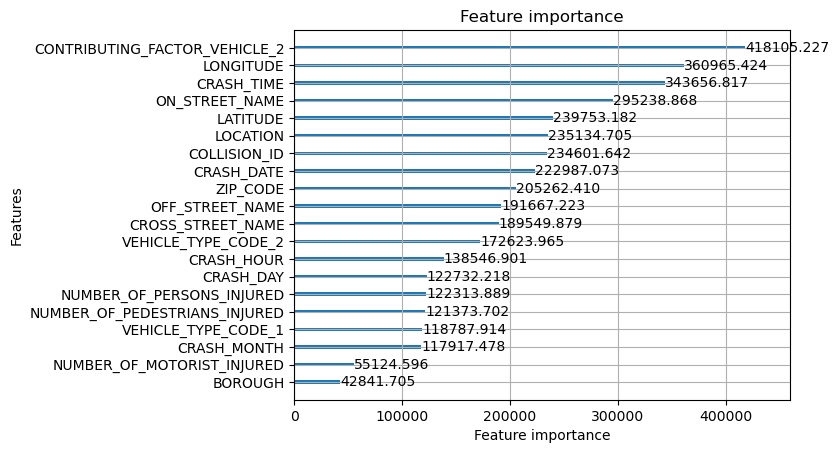

In [44]:
import matplotlib.pyplot as plt
lgb.plot_importance(gbm, max_num_features=20, importance_type='gain')
plt.show()

# Confusion Matrix

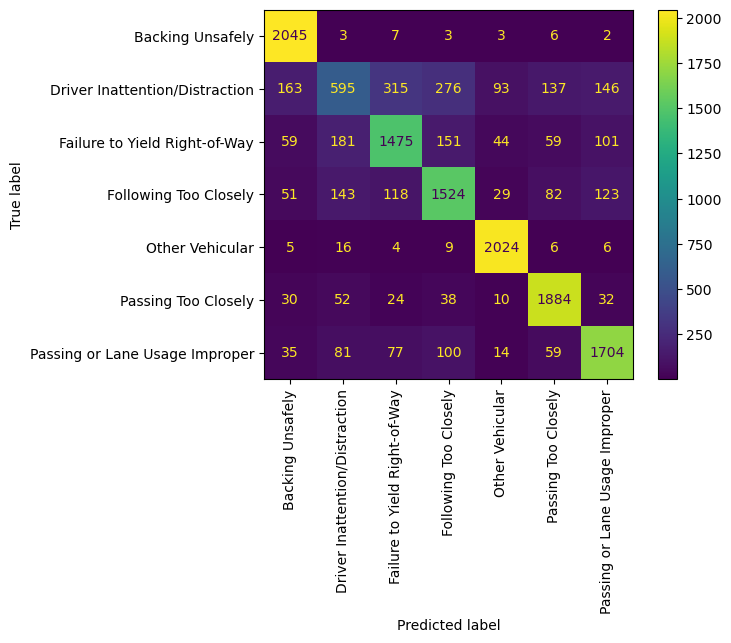

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val_enc, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_target.classes_)
disp.plot(xticks_rotation=90)
plt.show()

In [46]:
cm_df = pd.DataFrame(cm, index=le_target.classes_, columns=le_target.classes_)
accuracy_per_class = np.diag(cm) / cm.sum(axis=1)
pd.DataFrame({"class": le_target.classes_, "accuracy": accuracy_per_class})

,class,accuracy
0,Backing Unsafely,0.988400
1,Driver Inattention/Distraction,0.344928
2,Failure to Yield Right-of-Way,0.712560
3,Following Too Closely,0.736232
4,Other Vehicular,0.977778
5,Passing Too Closely,0.910145
6,Passing or Lane Usage Improper,0.823188


In [47]:
cm = confusion_matrix(y_val_enc, y_pred)
pd.DataFrame(cm, index=le_target.classes_, columns=le_target.classes_)

,Backing Unsafely,Driver Inattention/Distraction,Failure to Yield Right-of-Way,Following Too Closely,Other Vehicular,Passing Too Closely,Passing or Lane Usage Improper
Backing Unsafely,2045,3,7,3,3,6,2
Driver Inattention/Distraction,163,595,315,276,93,137,146
Failure to Yield Right-of-Way,59,181,1475,151,44,59,101
Following Too Closely,51,143,118,1524,29,82,123
Other Vehicular,5,16,4,9,2024,6,6
Passing Too Closely,30,52,24,38,10,1884,32
Passing or Lane Usage Improper,35,81,77,100,14,59,1704


## Confusion Matrix Insights

---

### 1️⃣ Observations from Raw Counts

**Key points:**
- **Backing Unsafely** and **Other Vehicular** are predicted very accurately.
- **Driver Inattention/Distraction**, **Failure to Yield Right-of-Way**, and **Following Too Closely** are often confused with each other.
- **Passing-related classes** (“Passing Too Closely” & “Passing or Lane Usage Improper”) show moderate confusion among themselves.

---

### 2️⃣ Patterns & Insights

1. **Driver Attention Confusions**  
   - Driver-related mistakes are frequently misclassified among each other.
   - Feature signals (time, vehicle type, location) may not sufficiently differentiate these behaviors.

2. **Passing Confusions**  
   - Lane/passing-related violations are occasionally misclassified.
   - Indicates need for better context-related features (e.g., road type, lane info).

3. **Well-Recognized Classes**  
   - “Backing Unsafely” and “Other Vehicular” are mostly correctly predicted, suggesting strong signal in the data.
   

4. **Driver Inattention/Distraction is low**

    - This class has many misclassifications, especially confused with Failure to Yield Right-of-Way and Following Too Closely.
    - Possible reasons:

        - Feature overlap: Time, vehicle type, and location may not sufficiently differentiate distracted driving from other driver-related mistakes.
        - Label noise: Police reports may classify similar behaviors differently, leading to inconsistent labeling for distractions.
        - Imbalanced representation: Even after oversampling, subtle patterns may be drowned out by more distinctive classes.

---


In [49]:
df.isnull().sum()

CRASH DATE                            0
CRASH TIME                            0
BOROUGH                           92062
ZIP CODE                          92100
LATITUDE                          23323
LONGITUDE                         23323
LOCATION                          23323
ON STREET NAME                    80942
CROSS STREET NAME                149040
OFF STREET NAME                  210864
NUMBER OF PERSONS INJURED             0
NUMBER OF PERSONS KILLED              0
NUMBER OF PEDESTRIANS INJURED         0
NUMBER OF PEDESTRIANS KILLED          0
NUMBER OF CYCLIST INJURED             0
NUMBER OF CYCLIST KILLED              0
NUMBER OF MOTORIST INJURED            0
NUMBER OF MOTORIST KILLED             0
CONTRIBUTING FACTOR VEHICLE 1      1900
CONTRIBUTING FACTOR VEHICLE 2     68528
CONTRIBUTING FACTOR VEHICLE 3    264772
CONTRIBUTING FACTOR VEHICLE 4    284608
CONTRIBUTING FACTOR VEHICLE 5    289638
COLLISION_ID                          0
VEHICLE TYPE CODE 1                4592
